# **General Descr**

in this notebook :

* I tried to implement a combo of  **NLP** and **machine learning** pipeline for **predicting clinical diagnoses** from unstructured free-text medical notes. I usedd **fine-tuned BERT**
 (Bidirectional_Encoder_Representations_from_Transformers) model to perform multi-class text classification.

* The model is trained on a dataset of 5000 labeled clinical entries to turn raw text into structured diagnostic predictions.

* and currently, I am working on integrating this system with FastAPI, enabling real-time predictions via an intuitive web interface for seamless deployment


# **Technical Highlights - pipeline - Implementation :**

1. **Chargement des données**

Lecture d’un dataset CSV contenant des notes cliniques (Clinical Notes) et des diagnostics (Diagnosis).

2. **Prétraitement**

Nettoyage du texte (mise en minuscule, suppression des chiffres, ponctuations, mots vides).

Encodage des labels de diagnostic avec LabelEncoder.

3. **Tokenisation**

Utilisation du tokenizer bert-base-uncased pour transformer les textes en vecteurs (input_ids, attention_mask) adaptés à BERT.

4. **Construction des datasets**

Création des jeux d'entraînement et de test avec la classe Dataset de HuggingFace.

5. **Fine-tuning du modèle BERT**

Modèle utilisé : BertForSequenceClassification.

Entraînement via la classe Trainer de HuggingFace avec paramètres spécifiques (taux d’apprentissage, epochs, batch size…).

6. **Évaluation**

Prédiction sur le jeu de test.

Génération d’un rapport de classification et d’une matrice de confusion.

7. **Export du modèle**

Sauvegarde du modèle fine-tuné, du tokenizer et du LabelEncoder pour une utilisation en production.

In [ ]:
import pandas as pd # load and manipulate tabular data
import nltk # Natural Language Toolkit, used for working with human language data
from nltk.corpus import stopwords # Loads common stopwords (like "the", "and") to remove them from text during preprocessing
import re # Provides regular expression tools for text cleaning (emoving special characters, digits)
import numpy as np #for numerical operations, arrays, and matrix manipulations
from sklearn.preprocessing import LabelEncoder #Converts text labels (e.g., diagnosis names) into numeric form for model training
from sklearn.model_selection import  train_test_split #Splits the dataset into training and testing sets
from transformers import BertTokenizer , BertForSequenceClassification , Trainer , TrainingArguments #Berts tools :
#BertTokenizer: Converts text into tokens that BERT understands
#BertForSequenceClassification: Pretrained BERT model for classification tasks
#Trainer, TrainingArguments: Helpers for training and evaluating the model
from datasets import Dataset #convert my data into a Hugging Face Dataset format compatible with the Trainer
from sklearn.metrics import classification_report , confusion_matrix # in order to evaluate my model performance
import seaborn as sns #Visualization library ->  used to plot confusion matrix as heatmaps
import matplotlib.pyplot as plt
import numpy as np
import pickle #to save and load Python objects like models and encoders to and from the disk
from transformers import BertForSequenceClassification , BertTokenizer
import pickle
import torch #PyTorch library  -> to work with tensors, models, and GPU acceleration
import shutil # to perform file operations :  copying or moving model files and directories
from google.colab import files

In [ ]:
data = pd.read_csv("clinical_notes_diagnosis_prediction_5000.csv")
data # displaying my data

,Clinical Notes,Diagnosis
0,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
1,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
2,A 50-year-old male with a history of diabetes ...,Septic Shock
3,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
4,A 55-year-old female with a history of obesity...,Type 2 Diabetes Mellitus
...,...,...
4995,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
4996,"A 40-year-old female presents with swelling, p...",Deep Vein Thrombosis
4997,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
4998,"A 40-year-old female presents with swelling, p...",Deep Vein Thrombosis


In [ ]:
data['Clinical Notes'][0]

'A 35-year-old male presents with heartburn, regurgitation, and a sour taste in his mouth, especially after meals. The patient has been self-medicating with over-the-counter antacids, but the symptoms persist. A 24-hour pH monitoring test confirms the diagnosis of GERD. The patient is started on a PPI and advised to avoid trigger foods.'

In [ ]:
data['Diagnosis'].value_counts()

,count
Diagnosis,
Peptic Ulcer Disease,284
Type 2 Diabetes Mellitus,283
Acute Myocardial Infarction,272
Chronic Obstructive Pulmonary Disease,269
Cerebrovascular Accident,263
Deep Vein Thrombosis,260
Community-Acquired Pneumonia,251
Chronic Kidney Disease,251
Septic Shock,246


preparing a list of common English words (and , which , on , ....)to remove from  our clinical notes :

    - why ? the model focus only  on important medical terms rather than filler words.

In [ ]:

nltk.download("stopwords")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


clean_text function : clean  and normalizes clinical notes :

- Lowercasing the text

- Removing numbers and punctuation

- Removing extra whitespace

- Removing common stopwords

why ? **not useful for diagnosis prediction**

In [ ]:
def clean_text(text):
  text = str(text).lower()
  text = re.sub(r'\d+' , '' , text) # removing digits
  text = re.sub(r'[^a-z\s]', '' , text) # removing everything which is not lowercase/space
  # like :punctuation marks , special symbols , non-letter characters
  text = re.sub(r'\s+', ' ' ,text).strip()#replacing white spaces with a single space
  #.strip() : to remove leading and trailing spaces
  text = ' '.join([word for word in text.split() if word not in stop_words])
  return text

data['Clinical Notes'] = data['Clinical Notes'].apply(clean_text)

In [ ]:
 data

,Clinical Notes,Diagnosis
0,yearold male presents heartburn regurgitation ...,Gastroesophageal Reflux Disease
1,yearold male history heavy alcohol use present...,Liver Cirrhosis
2,yearold male history diabetes presents hypoten...,Septic Shock
3,yearold male presents heartburn regurgitation ...,Gastroesophageal Reflux Disease
4,yearold female history obesity hypertension pr...,Type 2 Diabetes Mellitus
...,...,...
4995,yearold male history heavy alcohol use present...,Liver Cirrhosis
4996,yearold female presents swelling pain redness ...,Deep Vein Thrombosis
4997,yearold male history heavy alcohol use present...,Liver Cirrhosis
4998,yearold female presents swelling pain redness ...,Deep Vein Thrombosis


# **LabelEncoder**

*  encoding categorical labels from the Diagnosis column (which contains string values such as disease names)
---->   into numeric values
* why ? BERT require numerical labels

Applies label in order to encode 'Diagnosis' column of the dataset -->

**fit_transform()**
* Fit: Learn all unique categories in data['Diagnosis'] : Cancer, Flu , Diabetes ... ->  assigns an integer to each
* Transform: Replace  string labels with the corresponding integers , 0, 1, 2..

In [ ]:
# instance of the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the unique values in the {Diagnosis} column and transform them into integers

data['Diagnosis'] = label_encoder.fit_transform(data['Diagnosis'])

# At this point, 'data' has the 'Diagnosis' column encoded numerically
#Know displayin my data
data

,Clinical Notes,Diagnosis
0,yearold male presents heartburn regurgitation ...,9
1,yearold male history heavy alcohol use present...,11
2,yearold male history diabetes presents hypoten...,16
3,yearold male presents heartburn regurgitation ...,9
4,yearold female history obesity hypertension pr...,18
...,...,...
4995,yearold male history heavy alcohol use present...,11
4996,yearold female presents swelling pain redness ...,8
4997,yearold male history heavy alcohol use present...,11
4998,yearold female presents swelling pain redness ...,8


In [ ]:
train_texts , test_texts , train_labels , test_labels = train_test_split(data['Clinical Notes'], data['Diagnosis'], test_size=0.2 )

* 80% training notes - 80% training labels (integers)
* 80% Test notes - 20% Test labels (integers)

# **Tokenization part**

Preparing the Textuel data for input into the bert Model
rules :
* BERT Can't take raw text  -> **tokenized this inputs**  {
   - numerical representations oof the words ( **inputs IDs** )
   - **attention masks** : tell the BERT which parts of the input to pay attention to -----}
* result = compatible Inputs to the BERT MODEL

My case = use a pretrained_BERT_TOKENIZER from **HUGGING FACE**

# **encoding parametrs**


* padding = true -> pads all the sequences to the longest one / or max lentgh
* truncation: cuts off the sequences longer then 512(max_length)

The outputs(returns) of the tokenizer is (inputs ids , attention mask )
* inputs_ids = token ids for each word/subword
* attention_mask : 1 for real tokens . 0 for padding

exemple for the **padding / attention**
- Input sentence: "Patient has fever"
- input_ids:       [101, 1234, 4567, 7890, 102, 0, 0, 0]
- attention_mask:  [  1,    1,    1,    1,   1, 0, 0, 0]
- ? goal = differentiate and focus only on real word

In [ ]:
#!rm -rf ~/.cache/huggingface



tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# uncased -> convert all the text to lowercase and ignores capitalization

train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=512)
test_encodings =  tokenizer(list(test_texts), padding=True, truncation=True, max_length=512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

in this part - >
* convert the tokenized training and test data into  a dataset objects
* these object i will used them to train my BERT MODEL using hugging FACE Trainer API


The result of this part 2 dataset
- dataset: builed it as trainig dataset to train the  model
- 2nd dataset : build it for as  test dataset to test the model

Both datasets structured as :    
- inputs column
- attention mask column
- labels column

In [ ]:

#train_dataset = Dataset.from_dict({'inputs_ids': train_encodings['input_ids'], 'attention_mask':train_encodings['attention_mask'],'labels':train_labels.tolist()})
#test_dataset = Dataset.from_dict({'inputs_ids': test_encodings['input_ids'], 'attention_mask':test_encodings['attention_mask'],'labels':test_labels.tolist()})
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels.tolist()
    # tolist() to ensure the labels are in standard Python list format (not pandas Series).
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels.tolist()
})


In [ ]:
train_dataset[0]

{'input_ids': [101,
  2095,
  11614,
  2931,
  7534,
  5057,
  2533,
  5573,
  14447,
  11251,
  2157,
  2849,
  4190,
  2036,
  22889,
  3126,
  5596,
  4613,
  14931,
  12126,
  4167,
  7657,
  2003,
  5403,
  7712,
  6909,
  2187,
  2690,
  18439,
  16749,
  3700,
  5776,
  2318,
  16215,
  21716,
  14956,
  21252,
  7242,
  17785,
  24582,
  2226,
  3582,
  6279,
  27011,
  23283,
  11616,
  11325,
  2003,
  5403,
  7712,
  6909,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'labels': 17}

# Training Step

* load a pretrained **BERT_MODEL** for **classification**
* defines the trainiing config
* creating the trainer
* train the BERT MODEL on my tokenized clinical Notes and diagnosis labels

# **Training ARgs**

###**Weight_decay**
remember:
* in neural network : each neuron has a number of connections
* each connection has a number attached to it - > which is the weigh t
* now overfitting - >
   - very low error on training data
   - performs poorly on new/unseen data

* --> **weight_decay** : prevent overfitting
How >
   - adding a penalty if weights become too large
   - Encouraging the model to keep the weights smaller and simpler
* --> result : a model more general and robust :::  better at handling real-world data

### **Linear rate scheduler**
*  learning rate controls how fast the model updates during training
* linear scheduler starts from the initial learning rate like 2e-5 and gradually reduces it linearly down to 0 by the end of training
* why ?
   - at the start:  big updates help the model learn fast
   - near the end:  smaller steps make fine adjustments - >  help the model converge without jumping around

###**WARUMP**
Princip:
* the start of training :  the model can be unstable if the learning rate is too high --> use warmup steps ::: a phase where the learning rate starts very small and slowly increases to the original value.

###**load the best model**
princip :    
* During training: the model is evaluated after each epoch ---> checking how well it performs on unseen data
* Some epochs might give better results than others.
* After training finishes : reload the version of the model that had the lowest validation **loss** -->  not just the last one


###**gradient accumulation**
princip ⁉
* Normally -->  the model updates its weights after each batch of data

**BUT** : if my  GPU can't handle large batches --> what to do ?
- Should simulate large batches by accumulating gradients across multiple smaller steps

* my case = 2 : Calculate gradients from 2 mini-batches ---> then updates weights once

## **UNDERSTANDING RESUME**

| Parameter                       | Purpose                                                           |
| ------------------------------- | ----------------------------------------------------------------- |
| `weight_decay`                  | Prevents overfitting by keeping weights small (L2 regularization) |
| `lr_scheduler_type="linear"`    | Gradually reduces learning rate to help stabilize training        |
| `warmup_steps=500`              | Slowly increases learning rate at the start to avoid instability  |
| `load_best_model_at_end=True`   | Keeps the best model version based on validation performance      |
| `gradient_accumulation_steps=2` | Simulates larger batch sizes using small memory-efficient steps   |


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
# num_labels = the number of the outputs classes = the number of the diagnosis types
training_args = TrainingArguments(
    output_dir="./results",    # to save the  trained model checkpoints/logs
    eval_strategy="epoch",     #evaluate the model at the end of each training epoch
    save_strategy="epoch",     #save the model checkpoint at the end of every epoch
    learning_rate=2e-5,
            # The step size used by the optimizer to update model weights (how fast the model learns).

    per_device_train_batch_size=16,
        # Number of training examples fed to the model at once per GPU (or CPU if no GPU).

    per_device_eval_batch_size=16,
        # Number of evaluation examples processed at once per GPU/CPU during validation.

    num_train_epochs=5,     # Number of training epochs
    weight_decay=0.01,
    # Regularization technique that penalizes large weights to reduce overfitting (L2 penalty)

    logging_dir="./logs",

    # Folder where training logs (like loss values) will be stored.

    logging_steps=10,
        # Log training metrics (like loss) every 10 steps.


    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,

    metric_for_best_model="eval_loss",

    # Use evaluation loss (on validation set) to determine which model is the best.

    save_total_limit=3,
    # Keep only the 3 most recent saved model checkpoints to save storage space.

    gradient_accumulation_steps=2,
    report_to="none",
    # Don’t send logs to external tools like Weights & Biases (WandB).
)

#Trainer :  Hugging Face class:  handles training and evaluation automatically
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
)
# at thi s point : the  BERT  start learning how to predict the diagnosis from the clinical notes using the  datasets and settings
trainer.train()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,2.412300,2.241087
2,0.964200,0.726088
3,0.161400,0.098962
4,0.035300,0.024693
5,0.023200,0.016900


TrainOutput(global_step=625, training_loss=0.9901525354623795, metrics={'train_runtime': 321.6312, 'train_samples_per_second': 62.183, 'train_steps_per_second': 1.943, 'total_flos': 668163381600000.0, 'train_loss': 0.9901525354623795, 'epoch': 5.0})

## **Evaluation (Confusion Matrix & Classification Report )**

* Making predictions

* Extracting predicted class labels

* Comparing them to the true labels

* Printing a classification report (precision, recall, F1-score)

Detailed performance report ⁉
* Precision >>> how many predicted X were actually X?

* Recall >>> how many actual X were correctly predicted

* F1-score >>> the average of  precision and recall(balance between the two )

* Support>>> how many actual samples per class : number of true samples for each disease in the test set

In [ ]:
# the predictions : row scores output by the model for each class
# labels : the true values (labels )
#_ : other ignored infos like metrics , loss ...
predictions , labels , _ = trainer.predict(test_dataset)

#predictions : list of logits
#selecting only the index (class) with the highest score for each sample

predicted_labels = np.argmax(predictions , axis=1) # now we have list of only predicted class indices [(2,0,1 ...)]

# now we should convert the label-encoded claass numbers beck to their original string names
target_names = [str(label) for label in label_encoder.classes_]

print("classification Report:")
print(classification_report(test_labels , predicted_labels , target_names = target_names))


classification Report:
                                       precision    recall  f1-score   support

          Acute Myocardial Infarction       1.00      1.00      1.00        58
                  Acute Renal Failure       1.00      1.00      1.00        49
                               Asthma       1.00      1.00      1.00        51
             Cerebrovascular Accident       1.00      1.00      1.00        55
               Chronic Kidney Disease       1.00      1.00      1.00        49
Chronic Obstructive Pulmonary Disease       1.00      1.00      1.00        56
         Community-Acquired Pneumonia       1.00      1.00      1.00        59
             Congestive Heart Failure       1.00      1.00      1.00        43
                 Deep Vein Thrombosis       1.00      1.00      1.00        53
      Gastroesophageal Reflux Disease       1.00      1.00      1.00        41
                         Hypertension       1.00      1.00      1.00        56
                      Liver 

May be -
* my model learn very well
* too small dataset
* overfitting and mmemorization
* not enough diversity betweenthe test/train datast

### **Model's performance of each clsses -- Interpretation**

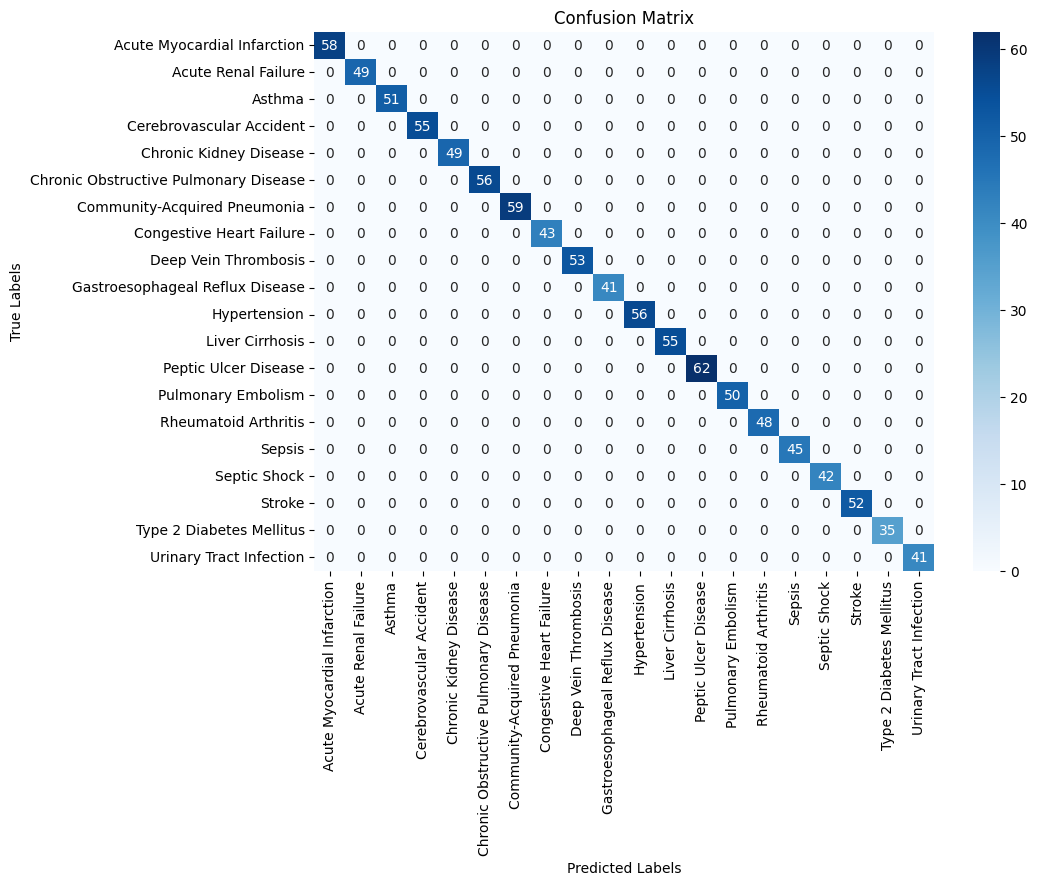

In [ ]:
cm = confusion_matrix(test_labels, predicted_labels )

plt.figure(figsize=(10,7))
sns.heatmap(cm , annot=True , fmt='d' , cmap ='Blues', xticklabels=target_names , yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# **Interpretation**

*  comparing the predicted true lables ( correcte disease ) with predicted labels
* row = real disease
* column = predicted diseas e by the model
* diagonal cells = correct predictions
* off-diagonal cells = wrong predictions

* for acture Myocardical Infr - > we can see that the model predicted 58 correct
* for the ASMA - > 51 PREDICTED CORRECTLY
* type 2 diabets mellitus ___> 35  
* few off-diagonal vlaues  -> rarely mistakes

## **Result**
* my model is very well - not confugsing disease with each other (because of the few error s 'off-diag cells')

# **Save the model and Implement Prediction System**

1 - saved the trained model wights

2 - saving tokenizer config

3 - saving label mapping (intgr , name)

4 - loading model / tokenizer

5 - loading label encoder to interept prediction results

In [ ]:
#saveing  the trained BERT model weights and configuration
trainer.save_model('./patient_model')

# saving  the optimizer state, scheduler state, RNG state (random number generator)
# whyy ?  useful if we want to resume training later from where we  stopped
trainer.save_state()


#saving  the tokenizer configuration and vocabulary
# why ?  when you reloading the model -->  the exact same tokenizer is used
tokenizer.save_pretrained('./patient_model')

# Serializes (saves) the LabelEncoder object to a .pkl file using pickle.
pickle.dump(label_encoder, open("label_encoder.pkl" , 'wb'))
# ---->
#saving  the mapping from class numbers (e.g., 0, 1, 2) back to original labels like 'Flu', 'Cancer'



# RELOAD the saved BERT model (architecture + weights) from disk for trying predictions
model = BertForSequenceClassification.from_pretrained('./patient_model')

#RELOAD  the tokenizer from the saved directory >>>same one used during training
tokenizer = BertTokenizer.from_pretrained('./patient_model')

with open("label_encoder.pkl" , 'rb') as f:
  label_encoder = pickle.load(f)



# **The prediction function**

 1. take new clinical notes as input
 2. cleans and tokeniz the text
 3. use the Trained BERT MODEL to predict the diagnosis
 4. converts the prediction (number) back to the origin diagnosis

In [ ]:



def predict_disease(patient_note , model , tokenizer , label_encoder):
  #2
  patient_note = clean_text(patient_note)
  inputs = tokenizer(patient_note , return_tensors='pt', padding =True , truncation=True , max_length=512)

  with torch.no_grad():   # disable gradient calculation -> because we ar just tpredicting not training
    outputs = model(**inputs) # returning object contain raw predictions
    logits = outputs.logits
    #the logits >>>>  raw scores """not yet probabilities""" for each possible diagnosis class

    #Find the index of the highest-scoring class (the predicted label)
    # argmax -> select only the class with the highest logit value
    predicted_label = torch.argmax(logits , dim=1).item()

    #Converts the numeric label like 1,2,..  back into its original string label
    predicted_disease = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_disease


### **TESTTTTT**

In [ ]:
patient_note = "Patient presents with fever , headach , and fatigue , Medical history includes hypertension."

predicted_disease = predict_disease(patient_note , model , tokenizer , label_encoder)

print(f"Predicted Disease: {predicted_disease}")

Predicted Disease: Acute Renal Failure


In [ ]:
patient_note = "'yearold male presents heartburn regurgitation sous taste mouth especially meals patient selfmedicating overthecounter antacids symptoms persist hour ph monitoring test"

predicted_disease = predict_disease(patient_note , model , tokenizer , label_encoder)

print(f"Predicted Disease: {predicted_disease}")

Predicted Disease: Gastroesophageal Reflux Disease


Download to pc

In [ ]:

shutil.make_archive('/content/patient_model', 'zip' , './patient_model')

files.download('/content/patient_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>